In [1]:
import os
import sys

from torch.nn.functional import dropout

# project root = one level up from notebooks/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
print("PROJECT_ROOT =", PROJECT_ROOT, "Exists? ->", os.path.exists(PROJECT_ROOT))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

from src.data.load_data import load_creditcard_data

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

plt.style.use("seaborn-v0_8")
sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PROJECT_ROOT = /home/linux/PyCharmMiscProject/projects/adaptive-cost-sensitive-loss Exists? -> True
Using device: cpu


In [2]:
# Load the same train/test split
X_train, y_train, X_test, y_test = load_creditcard_data(
    data_dir=os.path.join(PROJECT_ROOT, "data", "raw")
)

print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)
print("Train class count:\n", y_train.value_counts())
print("Test class count:\n", y_test.value_counts())

# scale features fro neural nets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

Train shape:  (227845, 30)
Test shape:  (56962, 30)
Train class count:
 Class
0    227451
1       394
Name: count, dtype: int64
Test class count:
 Class
0    56864
1       98
Name: count, dtype: int64


((227845, 30), (56962, 30))

In [11]:
from torch.utils.data import Dataset

class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: pd.Series):
        # X: (N, D), y: pandas Series of length N
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Return: features, label, sample_id
        return self.X[idx], self.y[idx], int(idx)


In [12]:
# Data loaders
batch_size = 512

train_dataset = TabularDataset(X_train_scaled, y_train)
test_dataset = TabularDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=False)

len(train_dataset), len(test_dataset)

(227845, 56962)

In [13]:
from src.models.mlp import MLPClassifier

input_dim = X_train_scaled.shape[1]
model = MLPClassifier(input_dim=input_dim).to(device)
model


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [14]:
# Metrics & cost helpers
def evaluate_sklearn_metrics(name, y_true, y_pred_labels, y_pred_probs):
    acc = accuracy_score(y_true, y_pred_labels)
    prec = precision_score(y_true, y_pred_labels, zero_division=0)
    rec = recall_score(y_true, y_pred_labels, zero_division=0)
    f1 = f1_score(y_true, y_pred_labels, zero_division=0)
    roc = roc_auc_score(y_true, y_pred_probs)
    pr_auc = average_precision_score(y_true, y_pred_probs)

    print(f"=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred_labels))
    print()

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }


def compute_cost(y_true, y_pred_labels, fn_cost=10.0, fp_cost=1.0):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fn * fn_cost + fp * fp_cost
    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "fn_cost": fn_cost, "fp_cost": fp_cost,
        "total_cost": total_cost
    }


In [15]:
# train/eval functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch, _ in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(dataloader.dataset)


@torch.no_grad()
def predict_on_loader(model, dataloader, device):
    model.eval()
    all_logits = []
    all_targets = []

    for X_batch, y_batch, _ in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        all_logits.append(logits.cpu())
        all_targets.append(y_batch.cpu())

    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    probs = torch.sigmoid(all_logits).numpy()
    return all_targets, probs


In [16]:
# Baseline 1: Plain BCEWithLogitsLoss
# train plain BCE model

# fresh model
# Fresh model
model_bce = MLPClassifier(input_dim=input_dim, hidden_dims=(64, 32), dropout=0.2).to(device)

criterion_bce = nn.BCEWithLogitsLoss()
optimizer_bce = torch.optim.Adam(model_bce.parameters(), lr=1e-3)

n_epochs = 10
train_losses = []

for epoch in range(1, n_epochs + 1):
    loss = train_one_epoch(model_bce, train_loader, criterion_bce, optimizer_bce, device)
    train_losses.append(loss)
    print(f"Epoch {epoch}/{n_epochs} - Train Loss: {loss:.4f}")


Epoch 1/10 - Train Loss: 0.0535
Epoch 2/10 - Train Loss: 0.0041
Epoch 3/10 - Train Loss: 0.0037
Epoch 4/10 - Train Loss: 0.0034
Epoch 5/10 - Train Loss: 0.0031
Epoch 6/10 - Train Loss: 0.0030
Epoch 7/10 - Train Loss: 0.0029
Epoch 8/10 - Train Loss: 0.0028
Epoch 9/10 - Train Loss: 0.0027
Epoch 10/10 - Train Loss: 0.0025


In [17]:
# evaluate BCE model

y_true_test, y_prob_test = predict_on_loader(model_bce, test_loader, device)

# default threshold 0.5
y_pred_test = (y_prob_test >= 0.5).astype(int)

results_torch = []
business_torch = []

res_bce = evaluate_sklearn_metrics("MLP (BCE)", y_true_test, y_pred_test, y_prob_test)
results_torch.append(res_bce)

cost_bce = compute_cost(y_true_test, y_pred_test, fn_cost=10.0, fp_cost=1.0)
cost_bce["model"] = "MLP (BCE)"
business_torch.append(cost_bce)

pd.DataFrame(business_torch)

=== MLP (BCE) ===
Accuracy:  0.9993
Precision: 0.8242
Recall:    0.7653
F1-score:  0.7937
ROC-AUC:   0.9766
PR-AUC:    0.8518

Confusion matrix:
[[56848    16]
 [   23    75]]



,tn,fp,fn,tp,fn_cost,fp_cost,total_cost,model
0,56848,16,23,75,10.0,1.0,246.0,MLP (BCE)


In [18]:
# baseline 2 : BCEWithLogitsLoss + pos_weight
# We compute pos_weight = num_neg / num_pos on train
# compute pos_weight

num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
pos_weight_value = num_neg / num_pos
pos_weight_value

577.2868020304569

In [19]:
# train weighted BCE model
model_bce_weighted = MLPClassifier(input_dim=input_dim, hidden_dims=(64, 32), dropout=0.2).to(device)

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
criterion_bce_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_bce_weighted = torch.optim.Adam(model_bce_weighted.parameters(), lr=1e-3)

n_epochs = 10
train_losses_w = []

for epoch in range(1, n_epochs + 1):
    loss = train_one_epoch(model_bce_weighted, train_loader, criterion_bce_weighted, optimizer_bce_weighted, device)
    train_losses_w.append(loss)
    print(f"[Weighted] Epoch {epoch}/{n_epochs} - Train Loss: {loss:.4f}")


[Weighted] Epoch 1/10 - Train Loss: 0.5839
[Weighted] Epoch 2/10 - Train Loss: 0.3180
[Weighted] Epoch 3/10 - Train Loss: 0.2592
[Weighted] Epoch 4/10 - Train Loss: 0.2489
[Weighted] Epoch 5/10 - Train Loss: 0.2214
[Weighted] Epoch 6/10 - Train Loss: 0.2050
[Weighted] Epoch 7/10 - Train Loss: 0.1998
[Weighted] Epoch 8/10 - Train Loss: 0.1925
[Weighted] Epoch 9/10 - Train Loss: 0.1660
[Weighted] Epoch 10/10 - Train Loss: 0.1547


In [20]:
# evaluate weighted BCE model
y_true_test_w, y_prob_test_w = predict_on_loader(model_bce_weighted, test_loader, device)
y_pred_test_w = (y_prob_test_w >= 0.5).astype(int)

res_bce_w = evaluate_sklearn_metrics("MLP (BCE + pos_weight)", y_true_test_w, y_pred_test_w, y_prob_test_w)
results_torch.append(res_bce_w)

cost_bce_w = compute_cost(y_true_test_w, y_pred_test_w, fn_cost=10.0, fp_cost=1.0)
cost_bce_w["model"] = "MLP (BCE + pos_weight)"
business_torch.append(cost_bce_w)

pd.DataFrame(business_torch)


=== MLP (BCE + pos_weight) ===
Accuracy:  0.9770
Precision: 0.0641
Recall:    0.9082
F1-score:  0.1197
ROC-AUC:   0.9781
PR-AUC:    0.7095

Confusion matrix:
[[55564  1300]
 [    9    89]]



,tn,fp,fn,tp,fn_cost,fp_cost,total_cost,model
0,56848,16,23,75,10.0,1.0,246.0,MLP (BCE)
1,55564,1300,9,89,10.0,1.0,1390.0,MLP (BCE + pos_weight)


In [21]:
def sweep_thresholds(y_true, y_proba, fn_cost=10.0, fp_cost=1.0, num_points=50):
    thresholds = np.linspace(0.01, 0.99, num_points)
    rows = []

    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        total_cost = fn * fn_cost + fp * fp_cost

        rows.append({
            "threshold": thr,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "total_cost": total_cost
        })

    return pd.DataFrame(rows)


In [22]:
# Threshold sweep for MLP BCE baseline
mlp_bce_sweep = sweep_thresholds(
    y_true_test,
    y_prob_test,
    fn_cost=10.0,
    fp_cost=1.0,
    num_points=50
)

# Show best thresholds (lowest cost)
mlp_bce_sweep.sort_values("total_cost").head(10)


,threshold,tn,fp,fn,tp,total_cost
11,0.23,56844,20,14,84,160.0
10,0.21,56842,22,14,84,162.0
8,0.17,56842,22,14,84,162.0
9,0.19,56842,22,14,84,162.0
6,0.13,56841,23,14,84,163.0
7,0.15,56841,23,14,84,163.0
5,0.11,56836,28,14,84,168.0
12,0.25,56844,20,15,83,170.0
14,0.29,56844,20,15,83,170.0
13,0.27,56844,20,15,83,170.0


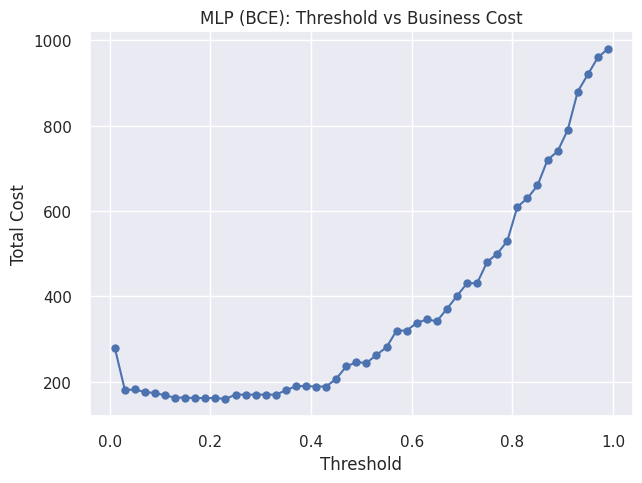

In [23]:
plt.figure(figsize=(7, 5))
plt.plot(mlp_bce_sweep["threshold"], mlp_bce_sweep["total_cost"], marker="o")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("MLP (BCE): Threshold vs Business Cost")
plt.grid(True)
plt.show()


In [26]:
# Threshold sweep for MLP BCE + pos_weight
mlp_bce_w_sweep = sweep_thresholds(
    y_true_test_w,
    y_prob_test_w,
    fn_cost=10.0,
    fp_cost=1.0,
    num_points=50
)

mlp_bce_w_sweep.sort_values("total_cost").head(10)


,threshold,tn,fp,fn,tp,total_cost
49,0.99,56825,39,15,83,189.0
48,0.97,56800,64,13,85,194.0
47,0.95,56735,129,12,86,249.0
46,0.93,56669,195,11,87,305.0
45,0.91,56626,238,11,87,348.0
44,0.89,56581,283,11,87,393.0
43,0.87,56549,315,11,87,425.0
42,0.85,56510,354,10,88,454.0
41,0.83,56472,392,10,88,492.0
40,0.81,56430,434,10,88,534.0


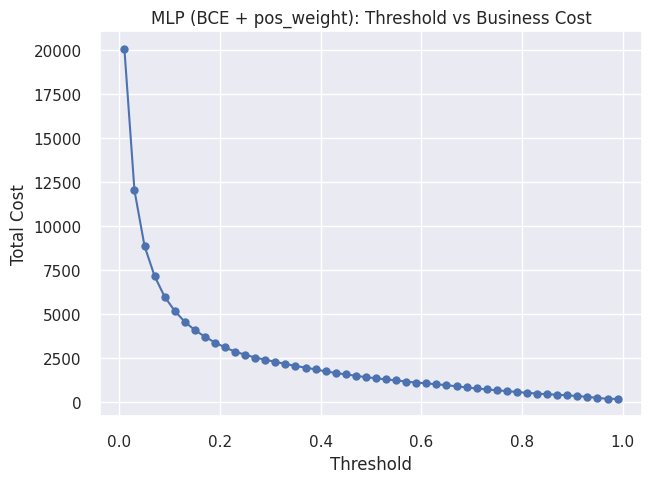

In [25]:
plt.figure(figsize=(7, 5))
plt.plot(mlp_bce_w_sweep["threshold"], mlp_bce_w_sweep["total_cost"], marker="o")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("MLP (BCE + pos_weight): Threshold vs Business Cost")
plt.grid(True)
plt.show()


In [53]:
from src.losses.adaptive_cost_sensitive import AdaptiveCostSensitiveLoss


In [54]:
n_train = len(train_dataset)

# One hardness value per training sample; start at zero
hardness = torch.zeros(n_train, dtype=torch.float32, device=device)
hardness.shape


torch.Size([227845])

In [55]:
def train_one_epoch_adaptive(
    model,
    dataloader,
    criterion,          # AdaptiveCostSensitiveLoss
    optimizer,
    device,
    hardness,
    ema_alpha: float = 0.9,
):
    """
    ema_alpha: how much to keep from old hardness (0.9 => slow, stable updates)
    """
    model.train()
    total_loss = 0.0

    for X_batch, y_batch, idx_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        idx_batch = idx_batch.to(device)

        optimizer.zero_grad()

        logits = model(X_batch)

        # criterion uses sample_ids + hardness
        loss, base_loss_det = criterion(
            logits,
            y_batch,
            sample_ids=idx_batch,
            hardness=hardness,
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

        # update hardness buffer with EMA of per-sample loss
        with torch.no_grad():
            old_h = hardness[idx_batch]
            new_h = ema_alpha * old_h + (1.0 - ema_alpha) * base_loss_det.to(device)
            hardness[idx_batch] = new_h

    epoch_loss = total_loss / len(dataloader.dataset)
    return epoch_loss, hardness


In [56]:
# fresh model
model_adapt = MLPClassifier(input_dim=input_dim, hidden_dims=(64, 32), dropout=0.2).to(device)

adaptive_criterion = AdaptiveCostSensitiveLoss(
    pos_cost=10.0,
    neg_cost=1.0,
    hardness_scale=1.0,   # how strongly hardness affects weights
).to(device)

optimizer_adapt = torch.optim.Adam(model_adapt.parameters(), lr=1e-3)

# reset hardness
hardness = torch.zeros(n_train, dtype=torch.float32, device=device)

n_epochs_adapt = 15
adapt_losses = []

for epoch in range(1, n_epochs_adapt + 1):
    loss, hardness = train_one_epoch_adaptive(
        model_adapt,
        train_loader,
        adaptive_criterion,
        optimizer_adapt,
        device,
        hardness,
        ema_alpha=0.9,
    )
    adapt_losses.append(loss)
    print(f"[Adaptive] Epoch {epoch}/{n_epochs_adapt} - Train Loss: {loss:.4f}")


[Adaptive] Epoch 1/15 - Train Loss: 0.0858
[Adaptive] Epoch 2/15 - Train Loss: 0.0349
[Adaptive] Epoch 3/15 - Train Loss: 0.0316
[Adaptive] Epoch 4/15 - Train Loss: 0.0290
[Adaptive] Epoch 5/15 - Train Loss: 0.0261
[Adaptive] Epoch 6/15 - Train Loss: 0.0262
[Adaptive] Epoch 7/15 - Train Loss: 0.0249
[Adaptive] Epoch 8/15 - Train Loss: 0.0240
[Adaptive] Epoch 9/15 - Train Loss: 0.0225
[Adaptive] Epoch 10/15 - Train Loss: 0.0218
[Adaptive] Epoch 11/15 - Train Loss: 0.0211
[Adaptive] Epoch 12/15 - Train Loss: 0.0202
[Adaptive] Epoch 13/15 - Train Loss: 0.0184
[Adaptive] Epoch 14/15 - Train Loss: 0.0176
[Adaptive] Epoch 15/15 - Train Loss: 0.0187


In [57]:
y_true_adapt, y_prob_adapt = predict_on_loader(model_adapt, test_loader, device)
y_pred_adapt = (y_prob_adapt >= 0.5).astype(int)

res_adapt = evaluate_sklearn_metrics(
    "MLP (Adaptive Cost-Sensitive Loss)",
    y_true_adapt,
    y_pred_adapt,
    y_prob_adapt,
)

cost_adapt = compute_cost(y_true_adapt, y_pred_adapt, fn_cost=10.0, fp_cost=1.0)
cost_adapt["model"] = "MLP (Adaptive Cost-Sensitive Loss)"

res_adapt, cost_adapt


=== MLP (Adaptive Cost-Sensitive Loss) ===
Accuracy:  0.9990
Precision: 0.6693
Recall:    0.8673
F1-score:  0.7556
ROC-AUC:   0.9784
PR-AUC:    0.8140

Confusion matrix:
[[56822    42]
 [   13    85]]



/tmp/ipykernel_10210/3255542422.py:38: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits))  # sigmoid


({'model': 'MLP (Adaptive Cost-Sensitive Loss)',
  'accuracy': 0.9990344440153085,
  'precision': 0.6692913385826772,
  'recall': 0.8673469387755102,
  'f1': 0.7555555555555555,
  'roc_auc': 0.9784232770204311,
  'pr_auc': 0.8139726092960318},
 {'tn': 56822,
  'fp': 42,
  'fn': 13,
  'tp': 85,
  'fn_cost': 10.0,
  'fp_cost': 1.0,
  'total_cost': 172.0,
  'model': 'MLP (Adaptive Cost-Sensitive Loss)'})

In [41]:
mlp_adapt_sweep = sweep_thresholds(
    y_true_adapt,
    y_prob_adapt,
    fn_cost=10.0,
    fp_cost=1.0,
    num_points=50
)

mlp_adapt_sweep.sort_values("total_cost").head(10)


,threshold,tn,fp,fn,tp,total_cost
38,0.77,56840,24,14,84,164.0
37,0.75,56836,28,14,84,168.0
30,0.61,56825,39,13,85,169.0
36,0.73,56834,30,14,84,170.0
35,0.71,56833,31,14,84,171.0
29,0.59,56823,41,13,85,171.0
28,0.57,56822,42,13,85,172.0
27,0.55,56821,43,13,85,173.0
24,0.49,56819,45,13,85,175.0
26,0.53,56819,45,13,85,175.0


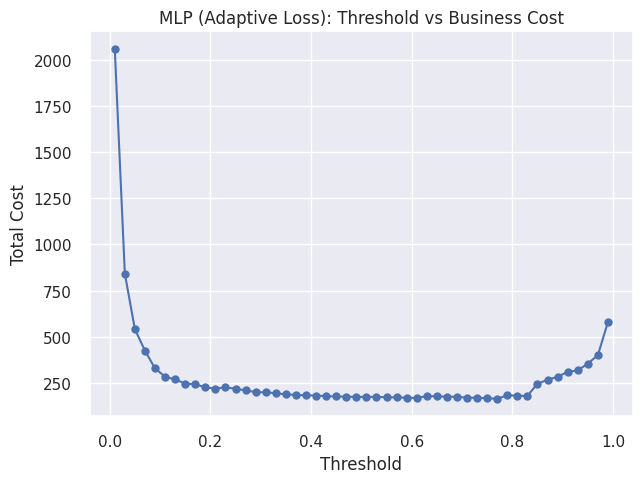

In [42]:
plt.figure(figsize=(7, 5))
plt.plot(mlp_adapt_sweep["threshold"], mlp_adapt_sweep["total_cost"], marker="o")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("MLP (Adaptive Loss): Threshold vs Business Cost")
plt.grid(True)
plt.show()


In [62]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)


def evaluate_sklearn_metrics(name, y_true, y_pred_labels, y_pred_probs):
    acc = accuracy_score(y_true, y_pred_labels)
    prec = precision_score(y_true, y_pred_labels, zero_division=0)
    rec = recall_score(y_true, y_pred_labels, zero_division=0)
    f1 = f1_score(y_true, y_pred_labels, zero_division=0)
    roc = roc_auc_score(y_true, y_pred_probs)
    pr_auc = average_precision_score(y_true, y_pred_probs)

    print(f"=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred_labels))
    print()

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc,
    }


def compute_cost(y_true, y_pred_labels, fn_cost=10.0, fp_cost=1.0):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fn * fn_cost + fp * fp_cost
    return {
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
        "fn_cost": float(fn_cost),
        "fp_cost": float(fp_cost),
        "total_cost": float(total_cost),
    }


@torch.no_grad()
def predict_on_loader(model, dataloader, device):
    """Stable sigmoid, no overflow."""
    model.eval()
    all_logits = []
    all_targets = []

    for X_batch, y_batch, _ in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        all_logits.append(logits.detach().cpu())
        all_targets.append(y_batch.detach().cpu())

    all_logits = torch.cat(all_logits, dim=0)          # tensor [N]
    all_targets = torch.cat(all_targets, dim=0).numpy()

    probs = torch.sigmoid(all_logits).numpy()          # stable sigmoid
    return all_targets, probs



from src.data.load_data import load_creditcard_data

X_train, y_train, X_test, y_test = load_creditcard_data(
    data_dir=os.path.join(PROJECT_ROOT, "data", "raw")
)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)

rf_clf.fit(X_train, y_train)

y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

rf_metrics = evaluate_sklearn_metrics("RandomForest (baseline)", y_test, y_pred_rf, y_proba_rf)
rf_cost = compute_cost(y_test, y_pred_rf, fn_cost=10.0, fp_cost=1.0)
rf_cost["model"] = "RandomForest (baseline)"



y_true_adapt, y_prob_adapt = predict_on_loader(model_adapt, test_loader, device)
y_pred_adapt = (y_prob_adapt >= 0.5).astype(int)

adapt_metrics = evaluate_sklearn_metrics(
    "MLP (Adaptive Cost-Sensitive Loss)",
    y_true_adapt,
    y_pred_adapt,
    y_prob_adapt,
)

adapt_cost = compute_cost(y_true_adapt, y_pred_adapt, fn_cost=10.0, fp_cost=1.0)
adapt_cost["model"] = "MLP (Adaptive Cost-Sensitive Loss)"



summary_rows = []

summary_rows.append({
    "model": rf_metrics["model"],
    "accuracy": rf_metrics["accuracy"],
    "precision": rf_metrics["precision"],
    "recall": rf_metrics["recall"],
    "f1": rf_metrics["f1"],
    "roc_auc": rf_metrics["roc_auc"],
    "pr_auc": rf_metrics["pr_auc"],
    "tn": rf_cost["tn"],
    "fp": rf_cost["fp"],
    "fn": rf_cost["fn"],
    "tp": rf_cost["tp"],
    "total_cost": rf_cost["total_cost"],
})

summary_rows.append({
    "model": adapt_metrics["model"],
    "accuracy": adapt_metrics["accuracy"],
    "precision": adapt_metrics["precision"],
    "recall": adapt_metrics["recall"],
    "f1": adapt_metrics["f1"],
    "roc_auc": adapt_metrics["roc_auc"],
    "pr_auc": adapt_metrics["pr_auc"],
    "tn": adapt_cost["tn"],
    "fp": adapt_cost["fp"],
    "fn": adapt_cost["fn"],
    "tp": adapt_cost["tp"],
    "total_cost": adapt_cost["total_cost"],
})

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("total_cost").reset_index(drop=True)

print("=== FINAL MODEL SUMMARY (sorted by total_cost) ===")
display(summary_df)


results_path = os.path.join(PROJECT_ROOT, "experiments", "final_model_summary.csv")
os.makedirs(os.path.dirname(results_path), exist_ok=True)
summary_df.to_csv(results_path, index=False)
print("Saved summary to:", results_path)

=== RandomForest (baseline) ===
Accuracy:  0.9996
Precision: 0.9419
Recall:    0.8265
F1-score:  0.8804
ROC-AUC:   0.9623
PR-AUC:    0.8730

Confusion matrix:
[[56859     5]
 [   17    81]]

=== MLP (Adaptive Cost-Sensitive Loss) ===
Accuracy:  0.9990
Precision: 0.6693
Recall:    0.8673
F1-score:  0.7556
ROC-AUC:   0.9784
PR-AUC:    0.8140

Confusion matrix:
[[56822    42]
 [   13    85]]

=== FINAL MODEL SUMMARY (sorted by total_cost) ===


,model,accuracy,precision,recall,f1,roc_auc,pr_auc,tn,fp,fn,tp,total_cost
0,MLP (Adaptive Cost-Sensitive Loss),0.999034,0.669291,0.867347,0.755556,0.978423,0.813973,56822,42,13,85,172.0
1,RandomForest (baseline),0.999614,0.941860,0.826531,0.880435,0.962346,0.873043,56859,5,17,81,175.0


Saved summary to: /home/linux/PyCharmMiscProject/projects/adaptive-cost-sensitive-loss/experiments/final_model_summary.csv
